# Age and Gender prediction

##Essential imports

In [1]:
import numpy as np 
import pandas as pd 
import os
import tensorflow as tf
import cv2
import requests
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dropout,Flatten,BatchNormalization,Dense,MaxPool2D,Conv2D,Input,Activation,Add
from tensorflow.keras.models import Model 
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam,Adagrad,Adadelta,Adamax,RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint
import plotly.graph_objects as go
import plotly.express as px
from sklearn.model_selection import train_test_split

home and folder directory paths.

In [2]:
home='/content'
fldr='/content/Data'


##Downloading the UTKFaces dataset
Ive downloaded it from Kaggle datasets and uploaded it to my github repo. 

In [3]:
!wget https://raw.githubusercontent.com/joeljose/age-gender-ethnicity-prediction/main/img_names.txt

--2021-12-08 14:39:22--  https://raw.githubusercontent.com/joeljose/age-gender-ethnicity-prediction/main/img_names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 897868 (877K) [text/plain]
Saving to: ‘img_names.txt’

img_names.txt       100%[===================>] 876.82K  --.-KB/s    in 0.05s   

2021-12-08 14:39:23 (15.6 MB/s) - ‘img_names.txt’ saved [897868/897868]



In [4]:
with open('img_names.txt') as file:
    files = file.readlines()
    files = [line.rstrip() for line in files]
print(len(files))
    

23708


In [5]:
!wget https://github.com/joeljose/age-gender-ethnicity-prediction/raw/main/Data.zip

--2021-12-08 14:39:23--  https://github.com/joeljose/age-gender-ethnicity-prediction/raw/main/Data.zip
Resolving github.com (github.com)... 52.69.186.44
Connecting to github.com (github.com)|52.69.186.44|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/joeljose/age-gender-ethnicity-prediction/main/Data.zip [following]
--2021-12-08 14:39:23--  https://media.githubusercontent.com/media/joeljose/age-gender-ethnicity-prediction/main/Data.zip
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 122184913 (117M) [application/zip]
Saving to: ‘Data.zip’

Data.zip            100%[===================>] 116.52M   170MB/s    in 0.7s    

2021-12-08 14:39:31 (170 MB/s) - ‘Data.zip’ saved [12218491

Unzipping the 'Data.zip' file we just downloaded.

In [6]:
!unzip /content/Data.zip

Streaming output truncated to the last 5000 lines.
  inflating: Data/45_0_3_20170119203905073.jpg.chip.jpg  
  inflating: Data/45_0_4_20170104184343710.jpg.chip.jpg  
  inflating: Data/45_0_4_20170104200726522.jpg.chip.jpg  
  inflating: Data/45_0_4_20170104202016610.jpg.chip.jpg  
  inflating: Data/45_1_0_20170110154302056.jpg.chip.jpg  
  inflating: Data/45_1_0_20170117174627560.jpg.chip.jpg  
  inflating: Data/45_1_1_20170113190400378.jpg.chip.jpg  
  inflating: Data/45_1_3_20170117194826185.jpg.chip.jpg  
  inflating: Data/45_1_3_20170119193037786.jpg.chip.jpg  
  inflating: Data/46_0_0_20170104205301379.jpg.chip.jpg  
  inflating: Data/46_0_0_20170108235049898.jpg.chip.jpg  
  inflating: Data/46_0_1_20170113173056321.jpg.chip.jpg  
  inflating: Data/46_0_1_20170117182528088.jpg.chip.jpg  
  inflating: Data/46_0_2_20170104205205795.jpg.chip.jpg  
  inflating: Data/46_0_3_20170109141827947.jpg.chip.jpg  
  inflating: Data/46_0_3_20170119195012113.jpg.chip.jpg  
  inflating: Data/46_

Checking if we got all the images.

In [7]:
os.chdir(fldr)
check = os.listdir()
print(len(check))

23708


##Preparing our data.

In [8]:
os.chdir(home)
ages = []
genders = []
images = []
for fle in files:
    age = int(fle.split('_')[0])
    gender = int(fle.split('_')[1])
    ages.append(age)
    genders.append(gender)
    total = fldr+'/'+fle
    # READ IMAGE
    image = cv2.imread(total)
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image=cv2.resize(image,(48,48))
    images.append(image)
print("Loaded the data into 3 lists")

Loaded the data into 3 lists


Lets take a look at a random data point

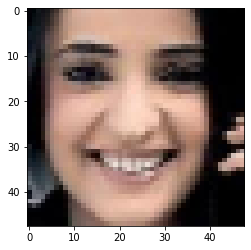

In [9]:
plt.imshow(images[876])

In [10]:
print(ages[876],genders[876])

22 1


Looks like gender is coded as '0' for 'male' and '1' for 'female'

In [11]:
print(len(ages),len(genders),len(images)) # just making sure the lists have same lengths

23708 23708 23708


Converting our lists to numpy arrays.

In [12]:
images_f = np.array(images)
ages_f = np.array(ages)
genders_f = np.array(genders)

Lets take a look at the distribution of our age and gender dataset.

In [13]:
# helper method to plot our data

def distribution_plot(x,y,name):
    fig = go.Figure([
        go.Bar(x=x, y=y)
    ])

    fig.update_layout(title_text=name)
    fig.show()

##Gender Distribution

In [14]:
values, counts=np.unique(genders_f,return_counts=True)
distribution_plot(x=values, y=counts, name='Gender Distribution')

##Age Distribution

In [16]:
values, counts=np.unique(ages_f,return_counts=True)
val = values.tolist()
cnt = counts.tolist()
distribution_plot(x=val, y=cnt, name='Age Distribution')

##train_test_split
We will merge gender and age data and then apply 'train_test_split'.
Then we take them out to apply them to our model.

In [17]:
labels =[]
i=0
while i<len(ages):
    label=[]
    label.append(ages[i])
    label.append(genders[i])
    labels.append(label)
    i=i+1

Normalize Pixel Values

In [18]:
images_f_2= images_f/255

In [19]:
images_f_2.shape

(23708, 48, 48, 3)

In [20]:
labels_f=np.array(labels)

In [21]:
len(labels_f)

23708

In [22]:
x_train, x_test, y_train, y_test = train_test_split(images_f_2, labels_f, test_size = 0.20)

splitting y_train because our model is multi output model.

In [23]:
y_train_2 = [y_train[:,1], y_train[:,0]]
y_test_2 = [y_test[:,1],y_test[:,0]]

##CNN Model

In [24]:
def Convolution(input_tensor, filters):
    x=Conv2D(filters=filters, kernel_size=(3,3),padding="same",strides=(1,1),kernel_regularizer=l2(0.001))(input_tensor)
    x=Dropout(0.1)(x)
    x=Activation('relu')(x)
    return x

In [25]:
def model(input_shape):
    inputs=Input((input_shape))
    conv_1=Convolution(inputs,32)
    maxp_1=MaxPool2D(pool_size=(2,2))(conv_1)
    
    conv_2=Convolution(maxp_1,64)
    maxp_2=MaxPool2D(pool_size=(2,2))(conv_2)
    
    conv_3=Convolution(maxp_2,128)
    maxp_3=MaxPool2D(pool_size=(2,2))(conv_3)
    
    conv_4=Convolution(maxp_3,256)
    maxp_4=MaxPool2D(pool_size=(2,2))(conv_4)
    
    flatten = Flatten()(maxp_4)
    dense_1 = Dense(64,activation='relu')(flatten)
    dense_2 = Dense(64,activation='relu')(flatten)
    
    drop_1 = Dropout(0.2)(dense_1)
    drop_2 = Dropout(0.2)(dense_2)
    
    output_1 = Dense(1,activation='sigmoid', name='sex_out')(drop_1)
    output_2 = Dense(1,activation='relu', name='age_out')(drop_2)
    model = Model(inputs=[inputs], outputs=[output_1,output_2])
    model.compile(loss=["binary_crossentropy","mae"],optimizer="Adam",metrics=["accuracy"])
    return model

In [26]:
Model = model((48,48,3))
Model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 48, 48, 32)   896         ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 48, 48, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 activation (Activation)        (None, 48, 48, 32)   0           ['dropout[0][0]']                
                                                                                              

Callbacks

In [27]:
file_save = 'Detection.h5'
checkpoint = ModelCheckpoint(file_save,monitor='val_loss',verbose=1,save_best_only=True,save_weights_only=False,mode='auto',save_freq='epoch')
Early_stop = tf.keras.callbacks.EarlyStopping(patience=75,monitor='val_loss',restore_best_weights=True)
callback_list=[checkpoint,Early_stop]

##Lets start training.

In [28]:
History = Model.fit(x_train,y_train_2,batch_size=64,validation_data=(x_test,y_test_2),epochs=250, callbacks=callback_list)

Epoch 1/250
297/297 [==============================] - ETA: 0s - loss: 16.4160 - sex_out_loss: 0.6950 - age_out_loss: 15.5306 - sex_out_accuracy: 0.5273 - age_out_accuracy: 0.0464
Epoch 00001: val_loss improved from inf to 16.97768, saving model to Detection.h5
297/297 [==============================] - 22s 33ms/step - loss: 16.4160 - sex_out_loss: 0.6950 - age_out_loss: 15.5306 - sex_out_accuracy: 0.5273 - age_out_accuracy: 0.0464 - val_loss: 16.9777 - val_sex_out_loss: 0.6782 - val_age_out_loss: 16.1135 - val_sex_out_accuracy: 0.5618 - val_age_out_accuracy: 0.0504
Epoch 2/250
295/297 [============================>.] - ETA: 0s - loss: 12.6223 - sex_out_loss: 0.6252 - age_out_loss: 11.7630 - sex_out_accuracy: 0.6425 - age_out_accuracy: 0.0450
Epoch 00002: val_loss improved from 16.97768 to 11.06276, saving model to Detection.h5
297/297 [==============================] - 8s 28ms/step - loss: 12.6169 - sex_out_loss: 0.6249 - age_out_loss: 11.7577 - sex_out_accuracy: 0.6427 - age_out_accu

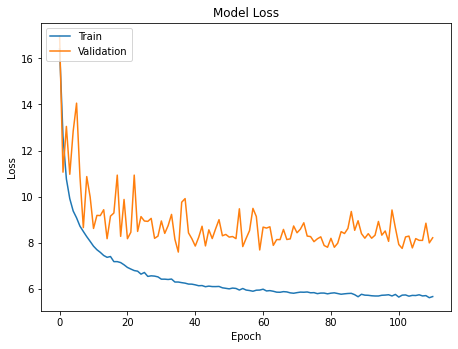

In [37]:
plt.plot(History.history['loss'])
# print(len(History.history['loss']))
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Validation'],loc='upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right=0.95,left=0,hspace=0.25,wspace=0.35)

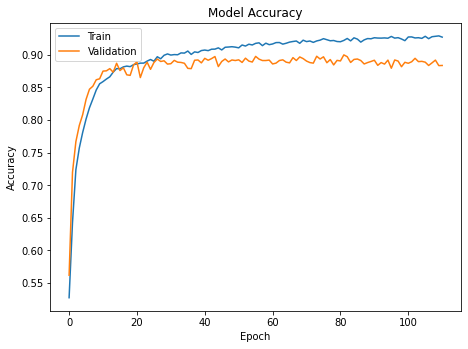

In [39]:
plt.plot(History.history['sex_out_accuracy'])
plt.plot(History.history['val_sex_out_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Validation'],loc='upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right=0.95,left=0,hspace=0.25,wspace=0.35)

##Lets Test out our model

In [40]:
def test_image(ind,images_f,images_f_2,Model):
    plt.imshow(images_f[ind])
    image_test=images_f_2[ind]
    pred_l= Model.predict(np.array([image_test]))
    sex_f=['Male','Female']
    age=int(np.round(pred_l[1][0]))
    sex=int(np.round(pred_l[0][0]))
    print("Predicted Age is "+ str(age))
    print("Predicted Gender is "+ sex_f[sex])
    print(f"Actual Age is {ages[ind]}")
    print(f"Actual Gender is {sex_f[genders[ind]]}")

Predicted Age is 54
Predicted Gender is Male
Actual Age is 69
Actual Gender is Male


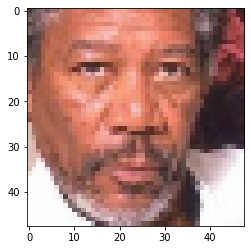

In [41]:
test_image(8,images_f,images_f_2,Model)

Predicted Age is 41
Predicted Gender is Female
Actual Age is 53
Actual Gender is Female


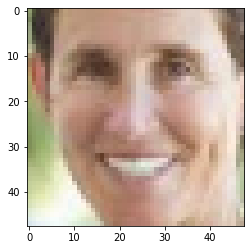

In [42]:
test_image(88,images_f,images_f_2,Model)

Predicted Age is 21
Predicted Gender is Male
Actual Age is 20
Actual Gender is Male


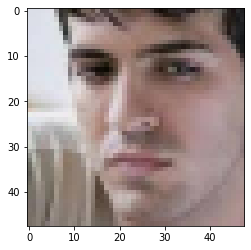

In [43]:
test_image(8877,images_f,images_f_2,Model)

Predicted Age is 8
Predicted Gender is Female
Actual Age is 8
Actual Gender is Female


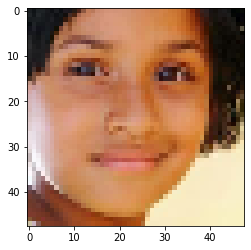

In [44]:
test_image(4578,images_f,images_f_2,Model)

Predicted Age is 86
Predicted Gender is Female
Actual Age is 85
Actual Gender is Female


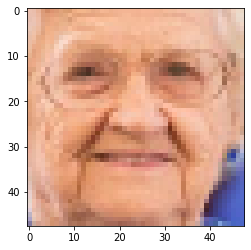

In [45]:
test_image(578,images_f,images_f_2,Model)

In [47]:
Model.save('final.h5')